# β对冲
By Evgenia "Jenny" Nitishinskaya and Delaney Granizo-Mackenzie with example algorithms by David Edwards

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)


---

##因素模型

因素模型是一种通过其他资产收益的线性组合来解释一种资产收益的方法。因子模型的一般形式是

$$Y = \alpha + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_n X_n$$

这看起来很熟悉，因为它正是线性回归所适合的模型类型。$X$也可以是指数，而不是资产。一个例子可能是分析师评估。

## 测试是什么?

一个资产对另一个资产的beta值就是上面模型中的$\beta$。例如，如果我们使用$Y_{TSLA} = \alpha + \beta X$模型对标准普尔500进行回归，那么TSLA对标准普尔500的beta风险敞口就是该beta。如果我们使用模型$Y_{TSLA} = \alpha + \beta X_{SPY} + \beta X_{AAPL}$，那么我们现在有两个beta，一个是TSLA对标普500的敞口，另一个是TSLA对AAPL的敞口。

通常，“贝塔”指的是一只股票对标准普尔500指数的贝塔风险敞口。我们将用它来表示，除非另有说明。

In [1]:
# Import libraries
import numpy as np
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


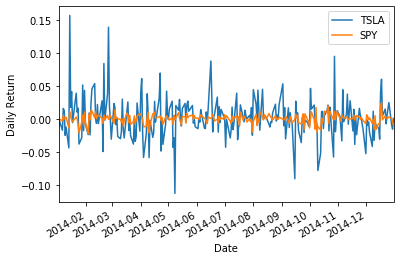

In [3]:
import yfinance as yf

# Get data for the specified period and stocks
start = '2014-01-01'
end = '2015-01-01'
asset = yf.download('TSLA', start, end)['Close']
asset.name='TSLA'
benchmark = yf.download('SPY',start,end)['Close']
benchmark.name='SPY'

# We have to take the percent changes to get to returns
# Get rid of the first (0th) element because it is NAN
r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]

# Let's plot them just for fun
r_a.plot()
r_b.plot()
plt.ylabel("Daily Return")
plt.legend();

现在我们可以执行回归，找到$\alpha$和$\beta$:

In [4]:
# Let's define everything in familiar regression terms
X = r_b.values # Get just the values, ignore the timestamps
Y = r_a.values

def linreg(x,y):
    # We add a constant so that we can also fit an intercept (alpha) to the model
    # This just adds a column of 1s to our data
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    # Remove the constant now that we're done
    x = x[:, 1]
    return model.params[0], model.params[1]

alpha, beta = linreg(X,Y)
print ('alpha: ' ,alpha)
print ('beta: ' ,beta)

alpha:  0.001134772330091096
beta:  1.9411397470619032


如果我们绘制直线$\alpha + \beta X$，我们可以看到它确实看起来像最佳拟合的直线:

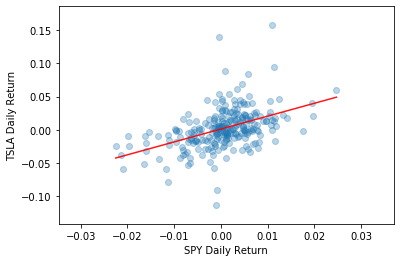

In [5]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha

plt.scatter(X, Y, alpha=0.3) # Plot the raw data
plt.xlabel("SPY Daily Return")
plt.ylabel("TSLA Daily Return")

 # Add the regression line, colored in red
plt.plot(X2, Y_hat, 'r', alpha=0.9);

## 风险敞口

更一般地说，这个贝塔系数是指你持有一项资产所承担的风险。如果一种资产对标准普尔500指数的风险敞口很高，那么，尽管它在市场上涨时表现很好，但在市场下跌时表现很差。高贝塔值对应高投机风险。你的押注更加不稳定。

在Quantopian，我们认为策略可以忽略尽可能多的因素。这意味着，战略中的所有回报都位于模型的$\alpha$部分，与其他因素无关。这是非常可取的，因为这意味着该战略是不可知的市场条件。它在崩盘时和在牛市时同样能赚钱。这些策略对拥有巨额现金池(如捐赠基金和外国财富基金)的个人最有吸引力。

## 风险管理

减少暴露于其他因素的过程称为风险管理。套期保值是实践中进行风险管理的最佳方式之一。

### 套期保值

如果我们通过这种关系确定我们投资组合的回报依赖于市场

$$Y_{portfolio} = \alpha + \beta X_{SPY}$$

然后我们可以在SPY采取一个空头头寸，以试图抵消这一风险。我们取出的金额是$-\beta V$，其中$V$是我们投资组合的总价值。这是可行的，因为如果我们的返回值近似为$\alpha + \beta X_{SPY}$，那么添加一个短的SPY将使我们的新返回值为$\alpha + \beta X_{SPY} - \beta X_{SPY} = \alpha$。我们的回报现在是纯粹的alpha，独立于SPY，不会在市场上有风险敞口。

### 市场中性

当一个策略表现出一致的贝塔值为0时，我们说这个策略是市场中性的。

### 评估的问题

这里的问题是，我们估计的beta并不一定会随着时间的推移而保持不变。因此，我们在SPY中所做的空头可能无法完美地对冲我们的投资组合，而且在实践中很难大幅降低贝塔系数。

在以后的课程中，我们会讨论更多关于参数估计的问题。简而言之，每个估计值都有一个标准误差，该误差与估计值在观测数据内的稳定性有关。

# 实现对冲

现在我们知道了要对冲多少，让我们看看它如何影响我们的回报。我们将使用该资产和基准构建我们的投资组合，以$-\beta$衡量基准(由于我们做空该资产，所以为负)。

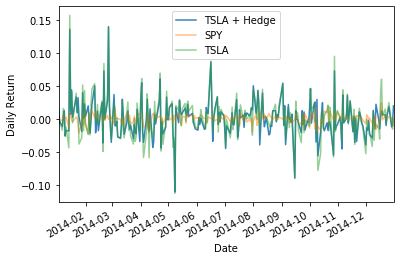

In [6]:
# Construct a portfolio with beta hedging
portfolio = -1*beta*r_b + r_a
portfolio.name = "TSLA + Hedge"

# Plot the returns of the portfolio as well as the asset by itself
portfolio.plot(alpha=0.9)
r_b.plot(alpha=0.5);
r_a.plot(alpha=0.5);
plt.ylabel("Daily Return")
plt.legend();

看起来，投资组合的回报与资产本身非常接近。我们可以通过计算两者的平均回报率和波动率(回报率的标准差)来量化它们的表现差异:

In [7]:
print ("means: ", portfolio.mean(), r_a.mean())
print ("volatilities: ", portfolio.std(), r_a.std())

means:  0.0011347723300910947 0.0020077921468307203
volatilities:  0.027130914575264568 0.030438363028190866


我们以牺牲一些回报为代价降低了波动性。让我们检查的阿尔法是一样的之前，而贝塔已被消除:

In [8]:
P = portfolio.values
alpha, beta = linreg(X,P)
print ('alpha: ' ,alpha)
print ('beta: ' ,beta)

alpha:  0.0011347723300910953
beta:  -5.967448757360216e-16


请注意，我们使用历史数据开发了我们的对冲策略。我们可以通过检查在不同时间段内资产和被套期投资组合的alpha和beta值来检查样本外是否仍然有效:

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Asset Historical Estimate:
alpha:  0.001134772330091096
beta:  1.9411397470619032
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Asset Out of Sample Estimate:
alpha:  0.0010978152759312696
beta:  1.038382661941816
Portfolio Out of Sample:
alpha:  0.0010978152759312705
beta:  -0.9027570851200881


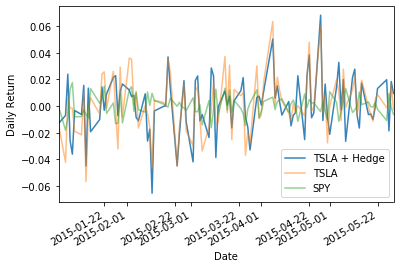

In [9]:
# Get the alpha and beta estimates over the last year
start = '2014-01-01'
end = '2015-01-01'
asset = yf.download('TSLA', start, end)['Close']
benchmark = yf.download('SPY', start, end)['Close']
asset.name='TSLA'
benchmark.name='SPY'
r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]
X = r_b.values
Y = r_a.values
historical_alpha, historical_beta = linreg(X,Y)
print('Asset Historical Estimate:') 
print ('alpha: ' ,historical_alpha)
print ('beta: ' ,historical_beta)

# Get data for a different time frame:
start = '2015-01-01'
end = '2015-06-01'
asset = yf.download('TSLA', start, end)['Close']
benchmark = yf.download('SPY', start, end)['Close']
asset.name='TSLA'
benchmark.name='SPY'

# Repeat the process from before to compute alpha and beta for the asset
r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]
X = r_b.values
Y = r_a.values
alpha, beta = linreg(X,Y)
print('Asset Out of Sample Estimate:') 
print ('alpha: ' ,alpha)
print ('beta: ' ,beta)

# Create hedged portfolio and compute alpha and beta
portfolio = -1*historical_beta*r_b + r_a
P = portfolio.values
alpha, beta = linreg(X,P)
print('Portfolio Out of Sample:') 
print ('alpha: ' ,alpha)
print ('beta: ' ,beta)


# Plot the returns of the portfolio as well as the asset by itself
portfolio.name = "TSLA + Hedge"
portfolio.plot(alpha=0.9)
r_a.plot(alpha=0.5);
r_b.plot(alpha=0.5)
plt.ylabel("Daily Return")
plt.legend();

正如我们所看到的，当我们观察样本外估计时，贝塔估计值变化很大。我们在历史数据上计算出的，并不能很好地降低我们投资组合的，但确实降低了1/2的幅度。

## α/β权衡

对冲市场等基准的确会降低你的回报率，而市场表现并不差。然而，这完全没问题。如果你的算法不那么不稳定，你就可以利用你的策略，将你的回报乘以原来的数量。更好的是，你的回报将比原来的波动贝塔暴露的战略稳定得多。

总的来说，尽管高贝塔系数的投资策略在市场增长时期的回报率非常高，因此往往具有欺骗性的吸引力，但从长期来看，它们是失败的，因为在市场低迷时期，它们将蒙受巨大损失。

# 其他类型的对冲

虽然我们不会在这里执行它们，但有些对冲策略可能更适合其他投资方式。

## 配对交易

一种是配对交易，在这种交易中，第二种资产被用来代替这里的基准。例如，这将允许您通过做多一家公司的股票和做空同一行业的另一家公司的股票来抵消行业中的波动。

[www.quantopian.com/lectures](https://www.quantopian.com/lectures)

## 长的短的股本

在这种情况下，我们定义了一组$n$个股票的排名，然后在相同的美元交易量中做多顶部的$p\%$和做空底部的$p\%$。相对于显式，当n较大时，它具有隐式对冲的优点。要了解为什么会出现这种情况，可以想象一下随机购买100种证券。这100家公司的市场风险贝塔值远低于1.0的几率非常低，因为我们已经对市场进行了大量的抽样调查。类似地，当我们按照某个独立指标排名并买入前100名股票时，我们选择总体贝塔系数远低于1.0的证券的几率很低。因此，在选择100多头和100空头时，策略应该非常接近1 - 1 = 0。显然，一些排名系统会引入样本偏差，并打破这一假设，例如根据估计的贝塔股权排名。

做多/做空股票策略的另一个好处是，你押注的是排名，或者换句话说，是排名靠前股票和排名靠后股票的表现差异。这意味着你甚至不必担心对冲中遇到的/的权衡。